In [41]:
import os
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import zoom
import CMR_HFpEF_Analysis.Image_utils as util
import CMR_HFpEF_Analysis.functions_collection as ff
import CMR_HFpEF_Analysis.motion_correction.Bspline as Bspline

main_path = '/mnt/mount_zc_NAS/HFpEF/'
save_path = os.path.join(main_path, 'pictures/manuscript')

# Get slice image

(128, 12)
(128, 90)


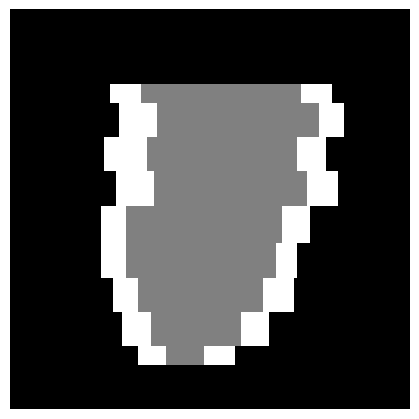

In [122]:
patient_id = '1256'
# filename = os.path.join('/mnt/mount_zc_NAS/HFpEF/data/contour_dataset/processed_HR_data/', patient_id, 'ED/HR_ED_zoomed_crop_flip_clean.nii.gz')
filename = os.path.join('/mnt/mount_zc_NAS/HFpEF/data/contour_dataset/simulated_data', patient_id, 'ED/normal_motion_12/data_clean.nii.gz')
img_file = nb.load(filename)
img = img_file.get_fdata()
img= util.relabel(np.round(img).astype(int),4,0)

# save slice image
ii = np.zeros([128,128])
plt.figure(figsize = (4,4))
a = img[:, 62, :]
print(a.shape)
# find which slices are not blank
slices = np.where(np.sum(a, axis = 0 ) > 0)[0]

# zoom
zoom_factor = 10 # 2.2 for HR, 10 for LR
a = zoom(a[:, slices[0] : slices[-1] + 1], [1,zoom_factor], order = 0)  
print(a.shape)

ii[:, slices[0]* int(zoom_factor) : slices[0]*int(zoom_factor)+ a.shape[-1]] = a
a = np.copy(ii.T)
a = util.move_heart_center_to_image_center(a, threshold = 0, large = True)

plt.imshow(a, 'gray')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig(os.path.join(save_path, patient_id,'LR_motion_12_slice_62.eps'), format='eps', bbox_inches='tight', pad_inches = 0)


# AI examples

In [30]:
patient_id = '1081'
filename = os.path.join(save_path, patient_id, 'LR_gt.nii.gz')
img_file1 = nb.load(filename)
img1 = img_file1.get_fdata()
img1 = util.relabel(np.round(img1).astype(int),4,0)

(128, 12)
(128, 100)


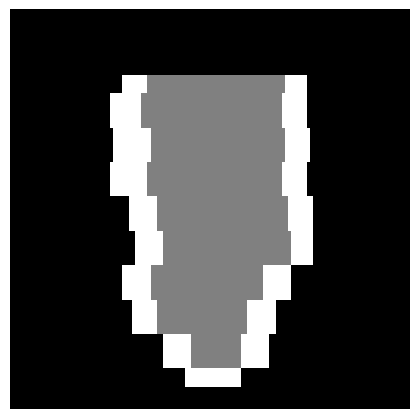

In [36]:
patient_id = '1081'
filename = os.path.join(save_path, patient_id, 'model_input.nii.gz')
img_file = nb.load(filename)
img = img_file.get_fdata()
img= util.relabel(np.round(img).astype(int),4,0)
img[:,:,-1] = img1[:,:,-1]

# save slice image
ii = np.zeros([128,128])
plt.figure(figsize = (4,4))
a = img[:, 60, :]
print(a.shape)
# find which slices are not blank
slices = np.where(np.sum(a, axis = 0 ) > 0)[0]

# zoom
zoom_factor = 10 # 2.2 for HR, 10 for LR
a = zoom(a[:, slices[0] : slices[-1] + 1], [1,zoom_factor], order = 0)  
print(a.shape)

ii[:, slices[0]* int(zoom_factor) : slices[0]*int(zoom_factor)+ a.shape[-1]] = a
a = np.copy(ii.T)
a = util.move_heart_center_to_image_center(a, threshold = 0, large = True)

plt.imshow(a, 'gray')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig(os.path.join(save_path, patient_id,'model_input_slice_60.eps'), format='eps', bbox_inches='tight', pad_inches = 0)


# SunnyBrook LAX

In [42]:
process_info = pd.read_excel(os.path.join(main_path, 'data/Sunny_Brooks', 'Sunny_Brooks_processing.xlsx'))
patient_id = 'SC-HYP-07'
results = np.load(os.path.join(main_path, 'predict/Sunny_Brooks/solution_4', patient_id, 'LAX_dice.npy'), allow_pickle = True)
# solution_4,pred_img_HR_3 vs. 4CH

In [46]:
# load prediction
pred_file = nb.load(os.path.join(main_path, 'predict/Sunny_Brooks/solution_4', patient_id, 'pred_img_HR_3.nii.gz'))
sax_data = pred_file.get_fdata()
sax_affine = nb.load(os.path.join(main_path, 'data/Sunny_Brooks/sunnybrooks_nii', patient_id, 'SAX_ED_endo.nii.gz')).affine
# process the prediction
row = process_info.loc[process_info['patient_id'] == patient_id]
sax_data = sax_data[:,:, row['start_index'].values[0] * 5 : row['end_index'].values[0] * 5]
sax_data = np.flip(sax_data, axis = 2)
sax_data = util.crop_or_pad(sax_data, (256,256,sax_data.shape[2]))
print(sax_data.shape)

# new sax affine
scale = [1,1, 1 / 5]
S = np.diag([scale[0], scale[1], scale[2], 1])
sax_affine_new = np.matmul(sax_affine, S)



(256, 256, 45)


In [51]:
# load LAX
names = ['LAX_2CH', 'LAX_3CH', 'LAX_4CH']
ii = 2
lax_epi_seg = nb.load(os.path.join(main_path, 'data/Sunny_Brooks/sunnybrooks_nii', patient_id, names[ii] + '_ED_epi.nii.gz')).get_fdata()
if len(lax_epi_seg.shape) == 4:
    lax_epi_seg = lax_epi_seg[:,:,0,:]
lax_epi_seg[lax_epi_seg > 0] = 1

lax_endo_seg = nb.load(os.path.join(main_path, 'data/Sunny_Brooks/sunnybrooks_nii', patient_id, names[ii] + '_ED_endo.nii.gz')).get_fdata()
if len(lax_endo_seg.shape) == 4:
    lax_endo_seg = lax_endo_seg[:,:,0,:]
lax_endo_seg[lax_endo_seg > 0] = 1

# lax contours:
lax_contour = np.copy(lax_epi_seg)
lax_contour[lax_contour> 0] = 2
lax_contour[lax_endo_seg > 0] = 1

lax_slice_num = np.where(np.sum(lax_contour, axis = (0,1)) > 0)[0][0]
print(lax_slice_num)

1


In [54]:
# reslice sax_data
X, Y, Z = np.meshgrid(np.arange(lax_contour.shape[0]), np.arange(lax_contour.shape[1]), np.arange(lax_slice_num, lax_slice_num+1))
grid_points = np.column_stack((X.flatten(), Y.flatten(), Z.flatten()))
converted_LAX_pts = ff.coordinate_convert(grid_points, sax_affine_new, nb.load(os.path.join(main_path, 'data/Sunny_Brooks/sunnybrooks_nii', patient_id, names[ii] + '_ED.nii.gz')).affine)

interpolation = ff.define_interpolation(sax_data, Fill_value=0, Method='nearest')
reslice = interpolation(converted_LAX_pts).reshape([lax_contour.shape[0], lax_contour.shape[1]]).T

(256, 256)


In [ ]:
# find out the contour points


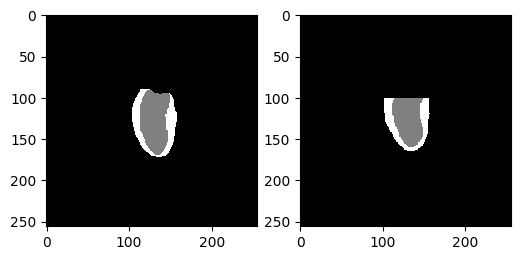

In [55]:
plt.figure(figsize = (6,3))
plt.subplot(121); plt.imshow(lax_contour[:,:,lax_slice_num], 'gray')
plt.subplot(122); plt.imshow(reslice, 'gray')